In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from itertools import product
from numpy.linalg import cholesky, inv
import plotly.graph_objs as go
import plotly.offline as po

In [10]:
df =[]
for c in ['USDCOP','SPX','USTTEN','XAU','EEM']:
    df.append(pd.read_csv(f'{c}_prob.csv',index_col=0))

df = pd.concat(df,axis=1)
df.columns = ['USDCOP','SPX','USTTEN','XAU','EEM']
df.to_csv('probs.csv')

In [31]:
r_ = pd.read_csv('m_returns.csv',index_col=0)
m_ = r_.loc[:'2020',:].add(1).apply(np.log).mean().mul(12)
corr_ = r_.loc[:'2020',:].add(1).apply(np.log).corr()
vol_ = r_.loc[:'2020',:].add(1).apply(np.log).std().mul(np.sqrt(12))

In [30]:
prs = pd.read_csv('probs.csv',index_col=0)


In [45]:

expret = [5,8,12,15]
expvol = [3,7,12,18]
corr = pd.DataFrame([[1,0.5,0.1,-0.6],[0.5,1.0,0.2,0.1],[0.1,0.2,1.0,0.5],[-0.6,0.1,0.5,1.0]],columns=expvol,index=expvol)
covar = corr.copy()
for i,j in product(expvol,repeat=2):
    covar.loc[i,j] = corr.loc[i,j]*i*j


    
x0 = [0.25,0.25,0.25,0.25]
bnds = ((0, 1), (0, 1),(0, 1),(-0.5, 1.5))

#minimize variance for each level of return
def por_var(x):
    return np.dot(np.matmul(x,covar),x)
def w(x):
    return np.sum(x[:3])-1

eff={}
ws={}
for i in range(min(expret)*2,max(expret)*2+1):
    r = i/2

    def port_ret(x):
        return np.dot(x,expret)-r
    cons= [{'type': 'eq', 'fun': port_ret},{'type': 'eq', 'fun': w}]
    res = minimize(por_var,x0,bounds=bnds,constraints=cons)
    eff[r] = np.sqrt(por_var(res.x))
    ws[r] = res.x

eff = pd.Series(eff)





In [120]:
#maximize return for each level of variance 
cons= [{'type': 'eq', 'fun': w}] #constraints for global minimum variance portfolio
gmvp = minimize(por_var,x0,bounds=bnds,constraints=cons) # weights of GMVP
min_v = np.sqrt(por_var(gmvp.x)) # minimum volatility possible
max_v = np.max(expvol)


def mvo(rr,covar):
    eff_v={}
    eff_x={}
    for q in range(int(np.ceil(min_v)),max_v+1,3):
        def varp(x):
            return np.dot(np.matmul(x,covar),x)-q**2
        def rfun(x):
            return -np.dot(x,rr)
        cons  = [{'type': 'eq', 'fun': varp},{'type': 'eq', 'fun': w}]
        res = minimize(rfun,x0,bounds=bnds,constraints=cons)

        eff_v[q] = -rfun(res.x)
        eff_x[q] = res.x

    return pd.Series(eff_v),pd.DataFrame(eff_x)

eff_v,xxx= mvo(expret,covar)

In [121]:
def scat(traces,annots=[]):
  layout = go.Layout(width=550,height=400,margin=dict(l=50,r=20,b=30,t=50),template='plotly_white',
                    annotations=annots,
                    showlegend=False,
                    title={'text':'<b>Efficient Frontier </b> ','xanchor':'left','font':{'size':10}},
                  )
  fig = go.Figure(data=traces, layout=layout)
  po.init_notebook_mode(connected=True)
  config = {'showLink':False}
  po.iplot(fig,config=config)

     

traces=[]
temp = eff.iloc[2:]
traces.append(go.Scatter(x=temp,y=temp.index,mode='lines+markers',line={'color':'dodgerblue'},marker={'size':6,'color':'blue'}))
traces.append(go.Scatter(x=eff_v.index,y=eff_v,mode='lines+markers',line={'color':'purple'},marker={'size':6,'color':'purple'}))
traces.append(go.Scatter(x=expvol,y=expret,mode='markers',marker={'size':7,'color':'red'},opacity=0.7))
annots = [{'x':temp.loc[i]+1.5,'y':i,'text':'('+str(temp.round(1).loc[i])+','+str(i)+')','showarrow':False,'font':{'size':8,'color':'blue'}} for i in temp.index]

scat(traces,annots)


In [23]:
#Resample eficient frontier:
# 1. 10k observations of uncorrelated random variables Z~N(0,1)
# 2. chelosky decompose correlation matrix to generate correlated random variables by transforming Z. 
# 3. correlated returns rij =  Mui + Zij*voli for each asset class i for each iteration j.
# 4. find eficient frontier at each iteration using correlated random returns found in 3. 
# 5. find the mean of the optimized weights at each pair r,vol on the EF. 
from numpy.linalg import cholesky
n = 200
C = cholesky(corr)
Zu = np.random.normal(size=(len(expret),n))
Zc = np.matmul(C,Zu).transpose()

Mu = np.tile(expret,(n,1))
S = np.tile(expvol,(n,1)) 
R = Mu + -(S**2/2)/100 +np.multiply(Zc,S)



In [24]:
ref_=[]
ws_=[]
for i in R:
    ri,wi =mvo(i)
    ref_.append(ri)
    ws_.append(wi)


In [59]:
wsdf = pd.concat(ws_,axis=1).transpose()
wsdf.round(2).mean()

0    0.228867
1    0.146917
2    0.149958
3    0.474292
dtype: float64

In [52]:
ref_df = pd.concat(ref_,axis=1).transpose()

mean_ref = ref_df.mean(axis=0)
traces=[]
temp = eff.iloc[2:]
traces.append(go.Scatter(x=eff_v.index,y=eff_v,mode='lines',line={'color':'purple'}))
traces.append(go.Scatter(x=expvol,y=expret,mode='markers',marker={'size':7,'color':'red'},opacity=0.7))
traces.append(go.Scatter(x=mean_ref.index,y=mean_ref,mode='lines',line={'color':'black'}))
for c in [3,6,9,12,15,18]:
     traces.append(go.Violin(y=ref_df.loc[:,c],jitter=0.2,pointpos=-0.5,
            points='outliers',name=c,side='negative',meanline_visible=True,
            marker={'size':2,'color':'black','opacity':0.4},line={'width':0.5,'color':'gray'}))
scat(traces)

In [51]:
traces=[]
traces.append(go.Scatter(x=Zc[:,0],y=Zc[:,3],mode='markers',marker={'color':'red','size':3.5},opacity=0.8))
traces.append(go.Scatter(x=Zu.T[:,0],y=Zu.T[:,3],mode='markers',marker={'color':'black','size':3},opacity=0.8))
print(corr)
scat(traces)

     3    7    12   18
3   1.0  0.5  0.1 -0.6
7   0.5  1.0  0.2  0.1
12  0.1  0.2  1.0  0.5
18 -0.6  0.1  0.5  1.0


<function matplotlib.pyplot.show(close=None, block=None)>

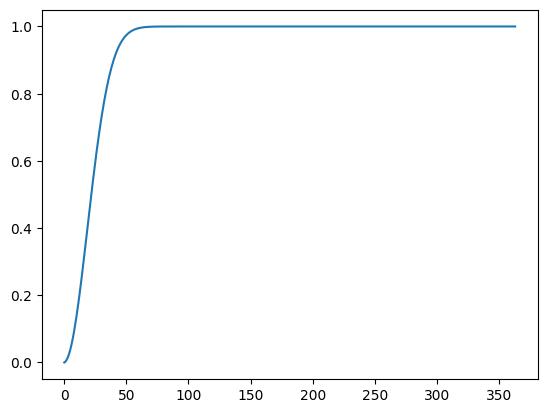

In [4]:
import math
import matplotlib.pyplot as plt
def birthday(k):
    return 1- math.factorial(365)/((365**k)*math.factorial(365-k))
    
x = [birthday(i) for i in range(1,365)]
plt.plot(x)
plt.show

In [104]:

corr = pd.DataFrame([[1,0.9,0.6],[0.9,1,0.7],[0.6,0.7,1]])
vol = [0.01,0.01,0.01]
C = cholesky(corr)
k = pd.Series([1,0,0])
r = np.multiply(np.matmul(C,k).transpose(),vol)
r

array([0.01 , 0.009, 0.006])

In [32]:
#BLACK LITTERMAN 
'''
insumos:
* retornos y covar (los mismos del mvo tradicional)
* un vector de recomendaciones q. en esta funcion esta pensado como  un numero de desviaciones. (ej +2 si es un view muy positivo en ese activo)
* un nivel de conviccion en el modelo.. entre mas alto c menos incertidumbre alrededor de los views. (puede estar en funcion del accuarcy del modelo por ejemplo) 
notas adicionales:
tau se puede sensiblizar pero el paper dice que usualmente es algo entre 0.025 y 0.05.. 
pick es una matriz de identidad porque tu siempre tienes views sobre todos los activos. (si tuvieras views sobre solo algunos pick deberia ser una matriz de 0s con 1s unicamente en 
los activos sobre los que se tiene un view...)
resultado:
la funcion devuelve un vector de retornos y covar posterior (osea ya ponderados usando los views y la conviccion que se tiene sobre ellos.)
'''

#BL optim
def BLopt(r,sigma,q,c,tau=0.025):
    pick = pick = np.eye(len(r))
    PEP = np.matmul(np.matmul(pick,sigma),pick.T)
    v = r + np.diag(sigma**(1/2))*q*np.sqrt(1/12) # r + 2(pr-0.5)*vol
    omega = PEP/c
    mu_bl = r + tau*np.matmul(np.matmul(sigma*pick.T,inv(tau*PEP+omega)),v-np.matmul(pick,r))
    sigma_bl = (1+tau)*sigma - tau**2*np.matmul(np.matmul(np.matmul(sigma,pick.T),inv(tau*PEP+omega)),np.matmul(pick,sigma))

    return mu_bl,sigma_bl


In [163]:
#EJEMPLO

expret = [5,8,12,15]
expvol = [3,7,12,18]
corr = pd.DataFrame([[1,0.5,0.1,-0.6],[0.5,1.0,0.2,0.1],[0.1,0.2,1.0,0.5],[-0.6,0.1,0.5,1.0]],columns=expvol,index=expvol)
sigma = corr.copy()
for i,j in product(expvol,repeat=2):
    sigma.loc[i,j] = corr.loc[i,j]*i*j


 #retornos 


In [164]:
# aqui es un ejemplo de REF tanto para el modelo tradicional como el que usa BL.

ref_=[]
ws_=[]
ws_bl=[]
ref_bl=[]
q = [1,-1,-2,-0.5]
c = 5
for i in R:
    mu_bl,sigma_bl = BLopt(i,sigma,q,c)
    ri,wi =mvo(i,sigma)
    rbl,wbl = mvo(mu_bl,sigma_bl)
    ref_.append(ri)
    ws_.append(wi)
    ws_bl.append(wbl)
    ref_bl.append(rbl)


In [165]:
print('Comparativo de pesoos objetivos bajo los dos modelos')
w_ = pd.concat(ws_,axis=1).T
wbl_ =pd.concat(ws_bl,axis=1).T
print('prior w')
print(w_.groupby(w_.index).mean())
print('posterior w')
print(wbl_.groupby(wbl_.index).mean())


Comparativo de pesoos objetivos bajo los dos modelos
prior w
           0         1         2         3
3   0.944436  0.038441  0.017123  0.140037
6   0.655986  0.241961  0.102053  0.173015
9   0.437970  0.382821  0.179209  0.287928
12  0.331984  0.403959  0.264056  0.473786
15  0.301754  0.410869  0.287377  0.653655
18  0.275253  0.422014  0.302734  0.826643
posterior w
           0         1         2         3
3   0.978091  0.017404  0.004505  0.174881
6   0.842644  0.122406  0.034950  0.307586
9   0.720173  0.210788  0.069039  0.451468
12  0.654350  0.239987  0.105663  0.618025
15  0.615783  0.261807  0.122410  0.782262
18  0.587265  0.275619  0.137116  0.944778


In [204]:
#ejemplo de solucion de minimos locales usando basinhopping
from scipy.optimize import basinhopping




expret = [0,6,10,25]
expvol = [2,10,15,28]
corr = pd.DataFrame([[1,0.5,0.1,-0.4],[0.5,1.0,0.2,0.1],[0.1,0.2,1.0,0.5],[-0.4,0.1,0.5,1.0]],columns=expvol,index=expvol)
covar = corr.copy()
for i,j in product(expvol,repeat=2):
    covar.loc[i,j] = corr.loc[i,j]*i*j


cons= [{'type': 'eq', 'fun': w}] #constraints for global minimum variance portfolio
gmvp = minimize(por_var,x0,bounds=bnds,constraints=cons) # weights of GMVP
min_v = np.sqrt(por_var(gmvp.x)) # minimum volatility possible
max_v = np.max(expvol)



def mvo(rr,covar):
    r_={}
    r_bh={}
    for q in range(int(np.ceil(min_v)),max_v+1,3):
        def varp(x):
            return np.dot(np.matmul(x,covar),x)-q**2
        def rfun(x):
            return -np.dot(x,rr)
        cons  = [{'type': 'eq', 'fun': varp},{'type': 'eq', 'fun': w}]
        res = minimize(rfun,x0,bounds=bnds,constraints=cons)
        res_ = basinhopping(rfun, x0, minimizer_kwargs={'bounds':bnds,'constraints':cons},niter=200)
        r_[q] = -rfun(res.x)
        r_bh[q] = -rfun(res_.x)

    return pd.Series(r_),pd.Series(r_bh)

r_,r_bh= mvo(expret,covar)




In [205]:
def scat(traces,annots=[]):
  layout = go.Layout(width=550,height=400,margin=dict(l=50,r=20,b=30,t=50),template='plotly_white',
                    annotations=annots,
                    showlegend=False,
                    title={'text':'<b>Comparativo minimize vs basinhopping </b> ','xanchor':'left','font':{'size':10}},
                  )
  fig = go.Figure(data=traces, layout=layout)
  po.init_notebook_mode(connected=True)
  config = {'showLink':False}
  po.iplot(fig,config=config)

     

traces=[]
temp = eff.iloc[2:]
traces.append(go.Scatter(x=r_bh.index,y=r_bh,mode='lines+markers',line={'color':'purple'},marker={'size':6,'color':'purple'}))
traces.append(go.Scatter(x=r_.index,y=r_,mode='lines+markers',line={'color':'blue'},marker={'size':6,'color':'blue'}))
traces.append(go.Scatter(x=expvol,y=expret,mode='markers',marker={'size':7,'color':'red'},opacity=0.7))

scat(traces)

In [ ]:
# BL usando probabilidades del modelo
prtest = prs.loc['2020-10':,:]
prtest
ref_=[]
ws_=[]
ws_bl=[]
ref_bl=[]

for i in R:
    mu_bl,sigma_bl = BLopt(i,sigma,q,c)
    ri,wi =mvo(i,sigma)
    rbl,wbl = mvo(mu_bl,sigma_bl)
    ref_.append(ri)
    ws_.append(wi)
    ws_bl.append(wbl)
    ref_bl.append(rbl)

,USDCOP,SPX,USTTEN,XAU,EEM
date,,,,,
2020-10-07,0.001410,0.006640,0.350663,0.077552,0.018273
2020-10-14,0.016871,0.002660,0.697250,0.990426,0.038311
2020-10-21,0.001314,0.007935,0.757681,0.961983,0.019321
2020-10-28,0.014559,0.000034,0.688108,0.925482,0.024267
2020-11-04,0.018835,0.002423,0.659116,0.967437,0.048562
...,...,...,...,...,...
2023-09-27,0.793741,0.000185,0.371877,0.707647,0.290332
2023-10-04,0.887781,0.030870,0.326329,0.137116,0.668805
2023-10-11,0.003558,0.456493,0.266860,0.121377,0.743038
